# Reflexion

[Reflexion](https://arxiv.org/abs/2303.11366) by Shinn, et. al., is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its responses for tasks to generate a higher quality final response, at the expense of longer execution time.

![reflexion diagram](../img/reflexion.png)

The paper outlines 3 main components:

1. Actor (agent) with self-reflection
2. External evaluator (task-specific, e.g. code compilation steps)
3. Episodic memory that stores the reflections from (1).

In their code, the last two components are very task-specific, so in this notebook, you will build the _actor_ in LangGraph.

To skip to the graph definition, see the [Construct Graph section](#Construct-Graph) below.

## 0. Prerequisites

Install `langgraph` (for the framework), `langchain_openai` (for the LLM), and `langchain` + `tavily-python` (for the search engine).

We will use tavily search as a tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a different tool of your choosing.

In [1]:
import os
import rich



In [2]:
# You could also use OpenAI or another provider
from langchain_openai import ChatOpenAI



## 1. Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:
1. Tools/tool execution
2. Initial responder: generate an initial response (and self-reflection)
3. Revisor: re-respond (and reflec) based on previous reflections

We'll first define the tool execution context.

#### Construct tools

In [3]:
from langchain_community.tools import DuckDuckGoSearchResults

search_internet = DuckDuckGoSearchResults(max_results=5)

tools = [search_internet]

#### State

In [4]:
from typing import Annotated, List, Optional, TypedDict, TypeVar, Type
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, filter_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages


class Reflection(BaseModel):
    missing: Optional[str] = Field(None, description="Critique of what is missing.")
    superfluous: Optional[str] = Field(None, description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: Optional[str] = Field(None, description="~250 word detailed answer to the question.")
    reflection: Optional[Reflection] = Field(None, description="Your reflection on the initial answer.")
    search_queries: Optional[List[str]] = Field(None,
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )
    

# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: Optional[List[str]] = Field(None,
        description="Citations motivating your updated answer."
    )
    

class State(TypedDict):
    """
    1. messages: 为所有 graph 的核心信息队列, 所有聊天工作流均应该将关键信息补充到此队列中.
    2. history: 为所有工作流单次启动时获取 history_len 的 messages 所用(节约成本, 及防止单轮对话 tokens 占用长度达到 llm 支持上限),
    history 中的信息理应是可以被丢弃的.
    3. question: 用户的问题.
    4. answer: 答案.
    5. reflection: Your reflection on the initial answer.
    6. search_queries: 1-3 search queries for researching improvements to address the critique of your current answer.
    7. references: Citations motivating your updated answer.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    history: Optional[List[BaseMessage]]
    question: Optional[List[BaseMessage]]
    answer: Optional[str]
    reflection: Optional[Reflection]
    search_queries: Optional[List[str]]
    references: Optional[List[str]]

#### history

In [5]:
# 定义一个类型变量，可以是各种 GraphState
T = TypeVar('T')


# 目的: 节约成本.
# 做法: 给 llm 传递历史上下文时, 把 AIMessage(Function Call) 和 ToolMessage 过滤, 只保留 history_len 长度的 AIMessage 作为历史上下文.
# todo: """目前 history_len 直接截取了 messages 长度, 希望通过 对话轮数 来限制.
#  原因: 一轮对话会追加数个 message, 但是目前没有从 snapshot(graph.get_state) 中找到很好的办法来获取一轮对话."""
def async_history_manager(state: T, history_len: int, exclude_types: Optional[List[Type[BaseMessage]]] = None) \
        -> T:
    try:
        if exclude_types is None:
            exclude_types = [ToolMessage]
        filtered_messages = []
        for message in filter_messages(state["messages"], exclude_types=exclude_types):
            if isinstance(message, AIMessage) and message.tool_calls:
                continue
            filtered_messages.append(message)
        state["history"] = filtered_messages[-history_len:]
        return state
    except Exception as e:
        raise Exception(f"Filtering messages error: {e}")

In [6]:
def history_manager(state: State) -> State:
    state = async_history_manager(state, 10)
    return state

## Create Sub Graph

#### Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool.

In [7]:
import datetime
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph import END

tool_node_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an excellent robot, good at invoking multiple functions (or the same function multiple times) to help users solve problems.
Current time: {time}

The following is a list of problems. Please call the appropriate tools in order and return the results:
{search_queries}
"""
        ),
    ]
).partial(time=lambda: datetime.datetime.now().isoformat())

function_call_graph_builder = StateGraph(State)

llm_with_tools = tool_node_template | llm.bind_tools(tools)

def function_call(state: State):
    if len(state["search_queries"]) == 0:
        state["search_queries"].append(state["history"])
    
    func_call = llm_with_tools.invoke(state)
    state["messages"] = [func_call]
    state["history"].append(func_call)
    return state

function_call_graph_builder.add_node("function_call", function_call)
tool_node = ToolNode(tools=tools)
function_call_graph_builder.add_node("tools", tool_node)

function_call_graph_builder.set_entry_point("function_call")
function_call_graph_builder.add_edge("function_call", "tools")
function_call_graph_builder.add_edge("tools", END)
function_call_graph = function_call_graph_builder.compile()

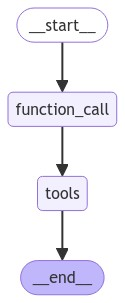

In [8]:
from IPython.display import Image, display

try:
    display(Image(function_call_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
# query = "How should we handle the climate crisis ?"
query = "Why do I need to learn Langgraph when studying LLM ?"

reflection = Reflection()

state = State(
    messages=[HumanMessage(content=query)],
    history=[HumanMessage(content=query)],
    question=[HumanMessage(content=query)],
    answer=None,
    reflection=reflection,
    search_queries=[],
    references=[]
)

rich.print(state)

{
    'messages': [HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?')],
    'history': [HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?')],
    'question': [HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?')],
    'answer': None,
    'reflection': Reflection(missing=None, superfluous=None),
    'search_queries': [],
    'references': []
}

In [10]:
async for events in function_call_graph.astream(state, stream_mode="updates"):
    for node, event in events.items():
        print(f"Step {node}")
        rich.print(event["messages"])
        if node == "tools":
            state["messages"].append(event["messages"])
            state["history"].append(event["messages"])

Step function_call


[
    AIMessage(
        content='',
        additional_kwargs={
            'tool_calls': [
                {
                    'index': 0,
                    'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                    'function': {
                        'arguments': '{"query":"Why learn Langgraph for studying LLM"}',
                        'name': 'duckduckgo_results_json'
                    },
                    'type': 'function'
                }
            ]
        },
        response_metadata={
            'finish_reason': 'tool_calls',
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_f33667828e'
        },
        id='run-7c2813da-b84c-45c2-9870-40c8382feb5d-0',
        tool_calls=[
            {
                'name': 'duckduckgo_results_json',
                'args': {'query': 'Why learn Langgraph for studying LLM'},
                'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                'type': 'tool_call'
            }
        ]
    )
]

Step tools


[
    ToolMessage(
        content='[snippet: Overall, I find LangGraph quite a powerful framework for building complex LLM 
applications: LangGraph is a low-level framework that offers extensive customisation options, allowing you to build
precisely what you need. ... LangGraph is the way to go. Keep in mind that you\'ll need to invest time in learning 
LangGraph and should be fully ..., title: From Basics to Advanced: Exploring LangGraph, link: 
https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787], [snippet: Welcome to 
"Building Knowledge Graph Solutions with LangGraph"! We are thrilled to have you embark on this journey to explore 
knowledge graphs and gain a comprehensive understanding of how to implement them using LangChain\'s LangGraph 
library, designed to create LLM applications and agents. Learn to build and implement knowledge graphs with ..., 
title: Building Knowledge Graph Solutions with LangGraph, link: 
https://adasci.org/courses/building-knowledge-graph-solutions-with-langgraph/], [snippet: Users can track their 
progress and set goals to stay motivated in their language learning journey. Langgraph also provides resources and 
tips to help learners practice and improve their skills ..., title: What is LangGraph and can it help you build LLM
Agents?, link: 
https://medium.com/indiciumtech/what-is-langgraph-and-can-it-help-you-build-llm-agents-c66b6def0b83], [snippet: 
Through its intuitive integration with LangChain and support for advanced functionalities, LangGraph paves the way 
for innovative LLM application development. Langgraph. Langchain., title: Introduction to LangGraph: Enhancing LLM 
Applications with ... - Medium, link: 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb]',
        name='duckduckgo_results_json',
        tool_call_id='call_IzvTOrqYTDSt4GHiR5ljL7p5'
    )
]

In [11]:
rich.print(state)

{
    'messages': [
        HumanMessage(
            content='Why do I need to learn Langgraph when studying LLM ?',
            id='6cd1881b-c944-4629-8fba-6de72b6341d9'
        ),
        [
            ToolMessage(
                content='[snippet: Overall, I find LangGraph quite a powerful framework for building complex LLM 
applications: LangGraph is a low-level framework that offers extensive customisation options, allowing you to build
precisely what you need. ... LangGraph is the way to go. Keep in mind that you\'ll need to invest time in learning 
LangGraph and should be fully ..., title: From Basics to Advanced: Exploring LangGraph, link: 
https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787], [snippet: Welcome to 
"Building Knowledge Graph Solutions with LangGraph"! We are thrilled to have you embark on this journey to explore 
knowledge graphs and gain a comprehensive understanding of how to implement them using LangChain\'s LangGraph 
library, designed to create LLM applications and agents. Learn to build and implement knowledge graphs with ..., 
title: Building Knowledge Graph Solutions with LangGraph, link: 
https://adasci.org/courses/building-knowledge-graph-solutions-with-langgraph/], [snippet: Users can track their 
progress and set goals to stay motivated in their language learning journey. Langgraph also provides resources and 
tips to help learners practice and improve their skills ..., title: What is LangGraph and can it help you build LLM
Agents?, link: 
https://medium.com/indiciumtech/what-is-langgraph-and-can-it-help-you-build-llm-agents-c66b6def0b83], [snippet: 
Through its intuitive integration with LangChain and support for advanced functionalities, LangGraph paves the way 
for innovative LLM application development. Langgraph. Langchain., title: Introduction to LangGraph: Enhancing LLM 
Applications with ... - Medium, link: 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb]',
                name='duckduckgo_results_json',
                id='4f1a9b35-e1a6-43cf-a106-641c3dfdd08b',
                tool_call_id='call_IzvTOrqYTDSt4GHiR5ljL7p5'
            )
        ]
    ],
    'history': [
        HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'index': 0,
                        'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                        'function': {
                            'arguments': '{"query":"Why learn Langgraph for studying LLM"}',
                            'name': 'duckduckgo_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'finish_reason': 'tool_calls',
                'model_name': 'gpt-4o-mini-2024-07-18',
                'system_fingerprint': 'fp_f33667828e'
            },
            id='run-7c2813da-b84c-45c2-9870-40c8382feb5d-0',
            tool_calls=[
                {
                    'name': 'duckduckgo_results_json',
                    'args': {'query': 'Why learn Langgraph for studying LLM'},
                    'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                    'type': 'tool_call'
                }
            ]
        ),
        [
            ToolMessage(
                content='[snippet: Overall, I find LangGraph quite a powerful framework for building complex LLM 
applications: LangGraph is a low-level framework that offers extensive customisation options, allowing you to build
precisely what you need. ... LangGraph is the way to go. Keep in mind that you\'ll need to invest time in learning 
LangGraph and should be fully ..., title: From Basics to Advanced: Exploring LangGraph, link: 
https://towardsdatascience.com/from-basics-to

#### Initial responder

In [12]:
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are an expert researcher.
Current time: {time}
User's question: {question}

Actions taken so far:
{history}

Initial Answer:
{answer}

Reflection on the initial answer:
{reflection}

Steps:
1. {first_instruction}
2. Reflect and critique your answer based on the user's question and the actions taken so far. Be severe to maximize improvement.
3. List information that needs further collection. Provide solutions only, no execution needed.
4. Respond using the {function_name} struct to provide an updated response.

Supporting References:
{references}
""",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)

def initial(state: State) -> State:
    initial_answer_chain = actor_prompt_template.partial(
        first_instruction="Provide correct and concise answers.",
        function_name=AnswerQuestion.__name__,
    ) | llm.with_structured_output(AnswerQuestion)
    
    initial_result = initial_answer_chain.invoke(state)
    
    rich.print(initial_result)
    
    if not isinstance(initial_result.reflection, dict):
        initial_result.reflection = initial_result.reflection.dict()
    if not isinstance(initial_result.search_queries, list):
        initial_result.search_queries = list(initial_result.search_queries)
    
    state["messages"] = [AIMessage(content=str(initial_result))]
    state["history"].append(AIMessage(content=str(initial_result)))
    state["answer"] = initial_result.answer
    state["reflection"] = initial_result.reflection
    state["search_queries"] = initial_result.search_queries
    
    return state

In [13]:
rich.print(initial(state))

AnswerQuestion(
    answer='Learning LangGraph is beneficial when studying Large Language Models (LLMs) for several reasons:\n\n1. 
**Framework for Building Applications**: LangGraph is a powerful framework designed specifically for creating 
applications that leverage LLMs. It provides a structured way to build complex applications, making it easier to 
implement various functionalities that LLMs can offer.\n\n2. **Customization and Flexibility**: One of the key 
advantages of LangGraph is its extensive customization options. This allows developers to tailor their applications
to meet specific needs, which is crucial when working with LLMs that can be applied in diverse domains.\n\n3. 
**Integration with LangChain**: LangGraph integrates seamlessly with LangChain, a popular library for building LLM 
applications. This integration enhances the capabilities of LLMs by allowing developers to utilize advanced 
features and functionalities, such as knowledge graphs and agent-based systems.\n\n4. **Learning Curve**: While 
there is a learning curve associated with LangGraph, the investment in time and effort can lead to a deeper 
understanding of how to effectively utilize LLMs in real-world applications. This knowledge can be invaluable for 
anyone looking to specialize in AI and machine learning.\n\n5. **Community and Resources**: Engaging with LangGraph
also connects you to a community of developers and resources that can provide support, tutorials, and best 
practices, further enhancing your learning experience.\n\nIn summary, learning LangGraph equips you with the tools 
and knowledge necessary to effectively harness the power of LLMs, making it a worthwhile endeavor for anyone 
serious about working in this field.',
    reflection=Reflection(
        missing='The initial answer did not provide a detailed explanation of the benefits of learning LangGraph in
the context of LLMs. It lacked specific examples and a structured approach to the answer.',
        superfluous='There was no superfluous information in the initial answer, but it could have been more 
concise and focused on the key points.'
    ),
    search_queries=[
        'Benefits of LangGraph for LLM applications',
        'LangGraph vs other frameworks for LLM',
        'How to integrate LangGraph with LLMs'
    ]
)

{
    'messages': [
        AIMessage(
            content="answer='Learning LangGraph is beneficial when studying Large Language Models (LLMs) for 
several reasons:\\n\\n1. **Framework for Building Applications**: LangGraph is a powerful framework designed 
specifically for creating applications that leverage LLMs. It provides a structured way to build complex 
applications, making it easier to implement various functionalities that LLMs can offer.\\n\\n2. **Customization 
and Flexibility**: One of the key advantages of LangGraph is its extensive customization options. This allows 
developers to tailor their applications to meet specific needs, which is crucial when working with LLMs that can be
applied in diverse domains.\\n\\n3. **Integration with LangChain**: LangGraph integrates seamlessly with LangChain,
a popular library for building LLM applications. This integration enhances the capabilities of LLMs by allowing 
developers to utilize advanced features and functionalities, such as knowledge graphs and agent-based 
systems.\\n\\n4. **Learning Curve**: While there is a learning curve associated with LangGraph, the investment in 
time and effort can lead to a deeper understanding of how to effectively utilize LLMs in real-world applications. 
This knowledge can be invaluable for anyone looking to specialize in AI and machine learning.\\n\\n5. **Community 
and Resources**: Engaging with LangGraph also connects you to a community of developers and resources that can 
provide support, tutorials, and best practices, further enhancing your learning experience.\\n\\nIn summary, 
learning LangGraph equips you with the tools and knowledge necessary to effectively harness the power of LLMs, 
making it a worthwhile endeavor for anyone serious about working in this field.' reflection={'missing': 'The 
initial answer did not provide a detailed explanation of the benefits of learning LangGraph in the context of LLMs.
It lacked specific examples and a structured approach to the answer.', 'superfluous': 'There was no superfluous 
information in the initial answer, but it could have been more concise and focused on the key points.'} 
search_queries=['Benefits of LangGraph for LLM applications', 'LangGraph vs other frameworks for LLM', 'How to 
integrate LangGraph with LLMs']"
        )
    ],
    'history': [
        HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'index': 0,
                        'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                        'function': {
                            'arguments': '{"query":"Why learn Langgraph for studying LLM"}',
                            'name': 'duckduckgo_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'finish_reason': 'tool_calls',
                'model_name': 'gpt-4o-mini-2024-07-18',
                'system_fingerprint': 'fp_f33667828e'
            },
            id='run-7c2813da-b84c-45c2-9870-40c8382feb5d-0',
            tool_calls=[
                {
                    'name': 'duckduckgo_results_json',
                    'args': {'query': 'Why learn Langgraph for studying LLM'},
                    'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                    'type': 'tool_call'
                }
            ]
        ),
        [
            ToolMessage(
                content='[snippet: Overall, I find LangGraph quite a powerful framework for building complex LLM 
applications: LangGraph is a low-level framework that offers extensive customisation options, allowing you to build
precisely what you need. ... LangGraph is the way to go. Keep in mind that you\'ll need to invest time in learning 
LangGraph and should be fully ..., title: From Basics to Advanc

In [14]:
async for events in function_call_graph.astream(state, stream_mode="updates"):
    for node, event in events.items():
        print(f"Step {node}")
        rich.print(event["messages"])
        if node == "tools":
            state["messages"].append(event["messages"])
            state["history"].append(event["messages"])

Step function_call


[
    AIMessage(
        content='',
        additional_kwargs={
            'tool_calls': [
                {
                    'index': 0,
                    'id': 'call_cRCfniKyi0FSmKbxv1sY1IQm',
                    'function': {
                        'arguments': '{"query": "Benefits of LangGraph for LLM applications"}',
                        'name': 'duckduckgo_results_json'
                    },
                    'type': 'function'
                },
                {
                    'index': 1,
                    'id': 'call_vcmZtTIqwk7NjfznbyPdYGBj',
                    'function': {
                        'arguments': '{"query": "LangGraph vs other frameworks for LLM"}',
                        'name': 'duckduckgo_results_json'
                    },
                    'type': 'function'
                },
                {
                    'index': 2,
                    'id': 'call_jAzvINEcNgHOGa6FWxDScMxR',
                    'function': {
                        'arguments': '{"query": "How to integrate LangGraph with LLMs"}',
                        'name': 'duckduckgo_results_json'
                    },
                    'type': 'function'
                }
            ]
        },
        response_metadata={
            'finish_reason': 'tool_calls',
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_f33667828e'
        },
        id='run-0d5c1a0a-1675-4612-981e-46ecae1fd258-0',
        tool_calls=[
            {
                'name': 'duckduckgo_results_json',
                'args': {'query': 'Benefits of LangGraph for LLM applications'},
                'id': 'call_cRCfniKyi0FSmKbxv1sY1IQm',
                'type': 'tool_call'
            },
            {
                'name': 'duckduckgo_results_json',
                'args': {'query': 'LangGraph vs other frameworks for LLM'},
                'id': 'call_vcmZtTIqwk7NjfznbyPdYGBj',
                'type': 'tool_call'
            },
            {
                'name': 'duckduckgo_results_json',
                'args': {'query': 'How to integrate LangGraph with LLMs'},
                'id': 'call_jAzvINEcNgHOGa6FWxDScMxR',
                'type': 'tool_call'
            }
        ]
    )
]

Step tools


[
    ToolMessage(
        content="Error: DuckDuckGoSearchException('https://duckduckgo.com Exception: Error in request: error 
sending request for url (https://duckduckgo.com/): error trying to connect: dns error: failed to lookup address 
information: nodename nor servname provided, or not known')\n Please fix your mistakes.",
        name='duckduckgo_results_json',
        tool_call_id='call_cRCfniKyi0FSmKbxv1sY1IQm'
    ),
    ToolMessage(
        content="[snippet: LangGraph: Multi-Agent Workflows. Links. Last week we highlighted LangGraph - a new 
package (available in both Python and JS) to better enable creation of LLM workflows containing cycles, which are a
critical component of most agent runtimes. As a part of the launch, we highlighted two simple runtimes: one that is
the equivalent of the ..., title: LangGraph: Multi-Agent Workflows - LangChain Blog, link: 
https://blog.langchain.dev/langgraph-multi-agent-workflows/], [snippet: Each option, whether it's the streamlined 
convenience of the Assistant API or the granular control offered by frameworks such as LangChain, LangGraph, 
Semantic Kernel, and AutoGen comes with its ..., title: A comparative overview of LangChain, Semantic Kernel, 
AutoGen and more, link: 
https://medium.com/data-science-at-microsoft/harnessing-the-power-of-large-language-models-a-comparative-overview-o
f-langchain-semantic-c21f5c19f93e], [snippet: This blog post delves into the foundational concepts of AI-driven 
multi-agent frameworks, discussing the role of large language models (LLMs), agents, tools, and processes in these 
systems. We'll also explore three leading frameworks—AutoGen, CrewAI, and LangGraph—comparing their features, 
autonomy levels, and ideal use cases, before ..., title: An Overview of Multi Agent Frameworks: Autogen, CrewAI and
LangGraph, link: https://sajalsharma.com/posts/overview-multi-agent-fameworks/], [snippet: Each agent can have its 
own prompt, LLM, tools, and other custom code to collaborate with other agents. However, the same LLM can also 
assume different roles based on the prompts provided. Using LangGraph for Multi-Agent Workflows. LangGraph is 
well-suited for creating multi-agent workflows because it allows two or more agents to be connected ..., title: 
Multiple AI Agents: Creating Multi-Agent Workflows Using LangGraph and ..., link: 
https://vijaykumarkartha.medium.com/multiple-ai-agents-creating-multi-agent-workflows-using-langgraph-and-langchain
-0587406ec4e6]",
        name='duckduckgo_results_json',
        tool_call_id='call_vcmZtTIqwk7NjfznbyPdYGBj'
    ),
    ToolMessage(
        content="[snippet: LangGraph stands out as a powerful tool for developers looking to harness the full 
potential of LLMs in building sophisticated, stateful applications with complex computational cycles., title: 
Introduction to LangGraph: Enhancing LLM Applications with Cyclic ..., link: 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb], [snippet: By integrating LangGraph with Ollama, Python developers can create more interactive and 
responsive applications. This example only scratches the surface of what's possible., title: Integrating LangGraph 
with Ollama for Advanced LLM Applications, link: 
https://medium.com/@lifanov.a.v/integrating-langgraph-with-ollama-for-advanced-llm-applications-d6c10262dafa], 
[snippet: LangGraph is a library built on top of LangChain and is fully compatible with the LangChain ecosystem. 
LangChain for context is an open-source Python and JavaScript framework that abstracts and facilitates interactions
between LLMs and external data sources, to create powerful LLM-powered applications. The architecture in LangChain 
revolves ..., title: LangGraph - cycling through multi-agent LLM applications - Scott Logic, link: 
https://blog.scottlogic.com/2024/05/13/langgraph-cycling-through-llm-applications.html], [snippet: LangGraph is a 
specialized library in the LangChai

In [15]:
rich.print(state)

{
    'messages': [
        AIMessage(
            content="answer='Learning LangGraph is beneficial when studying Large Language Models (LLMs) for 
several reasons:\\n\\n1. **Framework for Building Applications**: LangGraph is a powerful framework designed 
specifically for creating applications that leverage LLMs. It provides a structured way to build complex 
applications, making it easier to implement various functionalities that LLMs can offer.\\n\\n2. **Customization 
and Flexibility**: One of the key advantages of LangGraph is its extensive customization options. This allows 
developers to tailor their applications to meet specific needs, which is crucial when working with LLMs that can be
applied in diverse domains.\\n\\n3. **Integration with LangChain**: LangGraph integrates seamlessly with LangChain,
a popular library for building LLM applications. This integration enhances the capabilities of LLMs by allowing 
developers to utilize advanced features and functionalities, such as knowledge graphs and agent-based 
systems.\\n\\n4. **Learning Curve**: While there is a learning curve associated with LangGraph, the investment in 
time and effort can lead to a deeper understanding of how to effectively utilize LLMs in real-world applications. 
This knowledge can be invaluable for anyone looking to specialize in AI and machine learning.\\n\\n5. **Community 
and Resources**: Engaging with LangGraph also connects you to a community of developers and resources that can 
provide support, tutorials, and best practices, further enhancing your learning experience.\\n\\nIn summary, 
learning LangGraph equips you with the tools and knowledge necessary to effectively harness the power of LLMs, 
making it a worthwhile endeavor for anyone serious about working in this field.' reflection={'missing': 'The 
initial answer did not provide a detailed explanation of the benefits of learning LangGraph in the context of LLMs.
It lacked specific examples and a structured approach to the answer.', 'superfluous': 'There was no superfluous 
information in the initial answer, but it could have been more concise and focused on the key points.'} 
search_queries=['Benefits of LangGraph for LLM applications', 'LangGraph vs other frameworks for LLM', 'How to 
integrate LangGraph with LLMs']",
            id='189f0e06-aaeb-44e3-aac6-f528ca1df040'
        ),
        [
            ToolMessage(
                content="Error: DuckDuckGoSearchException('https://duckduckgo.com Exception: Error in request: 
error sending request for url (https://duckduckgo.com/): error trying to connect: dns error: failed to lookup 
address information: nodename nor servname provided, or not known')\n Please fix your mistakes.",
                name='duckduckgo_results_json',
                id='5e4b21b8-0995-45f0-af25-7c63ad870bb6',
                tool_call_id='call_cRCfniKyi0FSmKbxv1sY1IQm'
            ),
            ToolMessage(
                content="[snippet: LangGraph: Multi-Agent Workflows. Links. Last week we highlighted LangGraph - a 
new package (available in both Python and JS) to better enable creation of LLM workflows containing cycles, which 
are a critical component of most agent runtimes. As a part of the launch, we highlighted two simple runtimes: one 
that is the equivalent of the ..., title: LangGraph: Multi-Agent Workflows - LangChain Blog, link: 
https://blog.langchain.dev/langgraph-multi-agent-workflows/], [snippet: Each option, whether it's the streamlined 
convenience of the Assistant API or the granular control offered by frameworks such as LangChain, LangGraph, 
Semantic Kernel, and AutoGen comes with its ..., title: A comparative overview of LangChain, Semantic Kernel, 
AutoGen and more, link: 
https://medium.com/data-science-at-microsoft/harnessing-the-power-of-large-language-models-a-comparative-overview-o
f-langchain-semantic-c21f5c19f93e], [snippet: This blog post delves into the foundational concepts of AI-driven 
multi-agent frameworks, disc

#### Revision

The second part of the actor is a revision step.

In [16]:
def revision(state: State) -> State:
    revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer.
"""
    
    revision_chain = actor_prompt_template.partial(
        first_instruction=revise_instructions,
        function_name=ReviseAnswer.__name__,
    ) | llm.with_structured_output(ReviseAnswer)
    
    revised = revision_chain.invoke(state)
    
    rich.print(revised)
    
    if not isinstance(revised.reflection, dict):
        revised.reflection = revised.reflection.dict()
    if not isinstance(revised.search_queries, list):
        revised.search_queries = list(revised.search_queries)
    
    state["messages"] = [AIMessage(content=str(revised))]
    state["history"].append(AIMessage(content=str(revised)))
    state["answer"] = revised.answer
    state["reflection"] = revised.reflection
    state["search_queries"] = revised.search_queries
    state["references"] = revised.references
    
    return state

In [17]:
rich.print(revision(state))

ReviseAnswer(
    answer='Learning LangGraph is essential for studying Large Language Models (LLMs) for several compelling 
reasons:\n\n1. **Framework for Building Applications**: LangGraph is specifically designed for creating 
applications that leverage LLMs, providing a structured approach to building complex systems. This framework 
simplifies the implementation of various functionalities that LLMs can offer, making it easier to develop 
sophisticated applications.\n\n2. **Customization and Flexibility**: LangGraph offers extensive customization 
options, allowing developers to tailor their applications to meet specific needs. This flexibility is crucial when 
working with LLMs, which can be applied across diverse domains and use cases.\n\n3. **Integration with LangChain**:
LangGraph integrates seamlessly with LangChain, enhancing the capabilities of LLMs by enabling the use of advanced 
features such as knowledge graphs and agent-based systems. This integration allows for more powerful and efficient 
application development.\n\n4. **Learning Curve and Community Support**: While there is a learning curve associated
with LangGraph, the investment in mastering this framework can lead to a deeper understanding of LLMs and their 
applications. Additionally, engaging with LangGraph connects you to a community of developers and resources that 
provide support, tutorials, and best practices, enriching your learning experience.\n\nIn summary, learning 
LangGraph equips you with the necessary tools and knowledge to effectively harness the power of LLMs, making it a 
valuable endeavor for anyone serious about working in AI and machine learning.',
    reflection=Reflection(
        missing='The initial answer lacked specific examples and did not emphasize the practical applications of 
LangGraph in LLM development.',
        superfluous='The initial answer included some repetitive points that could be streamlined for clarity.'
    ),
    search_queries=[
        'Practical applications of LangGraph in LLM development',
        'LangGraph community resources and support',
        'Case studies using LangGraph with LLMs'
    ],
    references=[
        '[1] https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787',
        '[2] 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb',
        '[3] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/'
    ]
)

{
    'messages': [
        AIMessage(
            content="answer='Learning LangGraph is essential for studying Large Language Models (LLMs) for several 
compelling reasons:\\n\\n1. **Framework for Building Applications**: LangGraph is specifically designed for 
creating applications that leverage LLMs, providing a structured approach to building complex systems. This 
framework simplifies the implementation of various functionalities that LLMs can offer, making it easier to develop
sophisticated applications.\\n\\n2. **Customization and Flexibility**: LangGraph offers extensive customization 
options, allowing developers to tailor their applications to meet specific needs. This flexibility is crucial when 
working with LLMs, which can be applied across diverse domains and use cases.\\n\\n3. **Integration with 
LangChain**: LangGraph integrates seamlessly with LangChain, enhancing the capabilities of LLMs by enabling the use
of advanced features such as knowledge graphs and agent-based systems. This integration allows for more powerful 
and efficient application development.\\n\\n4. **Learning Curve and Community Support**: While there is a learning 
curve associated with LangGraph, the investment in mastering this framework can lead to a deeper understanding of 
LLMs and their applications. Additionally, engaging with LangGraph connects you to a community of developers and 
resources that provide support, tutorials, and best practices, enriching your learning experience.\\n\\nIn summary,
learning LangGraph equips you with the necessary tools and knowledge to effectively harness the power of LLMs, 
making it a valuable endeavor for anyone serious about working in AI and machine learning.' reflection={'missing': 
'The initial answer lacked specific examples and did not emphasize the practical applications of LangGraph in LLM 
development.', 'superfluous': 'The initial answer included some repetitive points that could be streamlined for 
clarity.'} search_queries=['Practical applications of LangGraph in LLM development', 'LangGraph community resources
and support', 'Case studies using LangGraph with LLMs'] references=['[1] 
https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787', '[2] 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb', '[3] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/']"
        )
    ],
    'history': [
        HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'index': 0,
                        'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                        'function': {
                            'arguments': '{"query":"Why learn Langgraph for studying LLM"}',
                            'name': 'duckduckgo_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'finish_reason': 'tool_calls',
                'model_name': 'gpt-4o-mini-2024-07-18',
                'system_fingerprint': 'fp_f33667828e'
            },
            id='run-7c2813da-b84c-45c2-9870-40c8382feb5d-0',
            tool_calls=[
                {
                    'name': 'duckduckgo_results_json',
                    'args': {'query': 'Why learn Langgraph for studying LLM'},
                    'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                    'type': 'tool_call'
                }
            ]
        ),
        [
            ToolMessage(
                content='[snippet: Overall, I find LangGraph quite a powerful framework for building complex LLM 
applications: LangGraph is a low-level framework that offers extensive customisation options, allowing you to build
precisely what you ne

In [18]:
async for events in function_call_graph.astream(state, stream_mode="updates"):
    for node, event in events.items():
        print(f"Step {node}")
        rich.print(event["messages"])
        if node == "tools":
            state["messages"].append(event["messages"])
            state["history"].append(event["messages"])

Step function_call


[
    AIMessage(
        content='',
        additional_kwargs={
            'tool_calls': [
                {
                    'index': 0,
                    'id': 'call_WOKZifycSLWBwAzyRYxxWep9',
                    'function': {
                        'arguments': '{"query": "Practical applications of LangGraph in LLM development"}',
                        'name': 'duckduckgo_results_json'
                    },
                    'type': 'function'
                },
                {
                    'index': 1,
                    'id': 'call_zxN9lHve9QWW3pbEgsgP8uT8',
                    'function': {
                        'arguments': '{"query": "LangGraph community resources and support"}',
                        'name': 'duckduckgo_results_json'
                    },
                    'type': 'function'
                },
                {
                    'index': 2,
                    'id': 'call_kMOnK3e1A85IIRIs2LPvvCrC',
                    'function': {
                        'arguments': '{"query": "Case studies using LangGraph with LLMs"}',
                        'name': 'duckduckgo_results_json'
                    },
                    'type': 'function'
                }
            ]
        },
        response_metadata={
            'finish_reason': 'tool_calls',
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_f33667828e'
        },
        id='run-2ee6961a-482f-4a2e-b650-148dab301e95-0',
        tool_calls=[
            {
                'name': 'duckduckgo_results_json',
                'args': {'query': 'Practical applications of LangGraph in LLM development'},
                'id': 'call_WOKZifycSLWBwAzyRYxxWep9',
                'type': 'tool_call'
            },
            {
                'name': 'duckduckgo_results_json',
                'args': {'query': 'LangGraph community resources and support'},
                'id': 'call_zxN9lHve9QWW3pbEgsgP8uT8',
                'type': 'tool_call'
            },
            {
                'name': 'duckduckgo_results_json',
                'args': {'query': 'Case studies using LangGraph with LLMs'},
                'id': 'call_kMOnK3e1A85IIRIs2LPvvCrC',
                'type': 'tool_call'
            }
        ]
    )
]

Step tools


[
    ToolMessage(
        content="[snippet: LLM-based applications like conversational AI applications often fail to maintain state,
memory, and context, which can degrade their output quality and performance. To overcome this drawback, LangChain 
has introduced LangGraph.This simplifies the creation and management of AI agents and their runtimes. It is 
uniquely suited for creating reliable, fault-tolerant agent-based systems., title: A Practical Guide to Building AI
Agents With LangGraph, link: https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/], [snippet:
LangGraph emerges as an innovative library designed to enhance the development of stateful, multi-actor LLM 
applications. Built as an extension of LangChain, LangGraph introduces advanced…, title: Introduction to LangGraph:
Enhancing LLM Applications with Cyclic ..., link: 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb], [snippet: Integrating LangGraph with Ollama for Advanced LLM Applications. LangGraph and Ollama are two 
cutting-edge libraries that, when combined, can significantly enhance the capabilities of Python ..., title: 
Integrating LangGraph with Ollama for Advanced LLM Applications, link: 
https://medium.com/@lifanov.a.v/integrating-langgraph-with-ollama-for-advanced-llm-applications-d6c10262dafa], 
[snippet: LangGraph is a library built on top of Langchain that empowers developers to construct stateful, 
multi-actor applications with LLMs. It extends Langchain's capabilities by introducing the ability to create 
cyclical graphs, enabling intricate agent-like behaviors. Unlike traditional LLM interactions that follow a 
prompt-answer paradigm ..., title: Building Stateful Applications with LangGraph - GoPenAI, link: 
https://blog.gopenai.com/building-stateful-applications-with-langgraph-860de3c9fa90]",
        name='duckduckgo_results_json',
        tool_call_id='call_WOKZifycSLWBwAzyRYxxWep9'
    ),
    ToolMessage(
        content="[snippet: LangGraph.js, in tandem with LangGraph Studio and Cloud, offers a comprehensive and 
powerful ecosystem for developing, debugging, and deploying innovative applications. By using the latest API ..., 
title: LangGraph Studio and Cloud for LangGraph.js introduced - Geeky Gadgets, link: 
https://www.geeky-gadgets.com/langgraph-studio/], [snippet: Today, we're announcing LangGraph Studio - the first 
IDE designed specifically for agent development - in open beta. LangGraph Studio offers a new way to develop LLM 
applications, providing a specialized agent IDE for visualizing, interacting with, and debugging complex agentic 
applications. In this blog, we'll give a brief overview of ..., title: LangGraph Studio: The first agent IDE - 
LangChain Blog, link: https://blog.langchain.dev/langgraph-studio-the-first-agent-ide/], [snippet: During my 
journey, I noticed a need for more beginner-friendly resources, especially for the TypeScript implementation, and 
found that the official documentation was still in progress. Through this guide, I aim to bridge that gap and 
showcase the potential of LangGraph.js and Langchain for creating LLM-powered products., title: An Absolute 
Beginner's Guide to LangGraph.js, link: 
https://techcommunity.microsoft.com/t5/educator-developer-blog/an-absolute-beginner-s-guide-to-langgraph-js/ba-p/42
12496], [snippet: LangChain is one of the leading frameworks for building applications powered by Lardge Language 
Models. With the LangChain Expression Language (LCEL), defining and executing step-by-step action sequences — also 
known as chains — becomes much simpler. In more technical terms, LangChain allows us to create DAGs (directed 
acyclic graphs). As LLM applications, particularly LLM agents, have ..., title: From Basics to Advanced: Exploring 
LangGraph, link: https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787]",
        name='duckduckgo_results_json',
     

In [19]:
rich.print(state)

{
    'messages': [
        AIMessage(
            content="answer='Learning LangGraph is essential for studying Large Language Models (LLMs) for several 
compelling reasons:\\n\\n1. **Framework for Building Applications**: LangGraph is specifically designed for 
creating applications that leverage LLMs, providing a structured approach to building complex systems. This 
framework simplifies the implementation of various functionalities that LLMs can offer, making it easier to develop
sophisticated applications.\\n\\n2. **Customization and Flexibility**: LangGraph offers extensive customization 
options, allowing developers to tailor their applications to meet specific needs. This flexibility is crucial when 
working with LLMs, which can be applied across diverse domains and use cases.\\n\\n3. **Integration with 
LangChain**: LangGraph integrates seamlessly with LangChain, enhancing the capabilities of LLMs by enabling the use
of advanced features such as knowledge graphs and agent-based systems. This integration allows for more powerful 
and efficient application development.\\n\\n4. **Learning Curve and Community Support**: While there is a learning 
curve associated with LangGraph, the investment in mastering this framework can lead to a deeper understanding of 
LLMs and their applications. Additionally, engaging with LangGraph connects you to a community of developers and 
resources that provide support, tutorials, and best practices, enriching your learning experience.\\n\\nIn summary,
learning LangGraph equips you with the necessary tools and knowledge to effectively harness the power of LLMs, 
making it a valuable endeavor for anyone serious about working in AI and machine learning.' reflection={'missing': 
'The initial answer lacked specific examples and did not emphasize the practical applications of LangGraph in LLM 
development.', 'superfluous': 'The initial answer included some repetitive points that could be streamlined for 
clarity.'} search_queries=['Practical applications of LangGraph in LLM development', 'LangGraph community resources
and support', 'Case studies using LangGraph with LLMs'] references=['[1] 
https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787', '[2] 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb', '[3] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/']",
            id='bfd005f0-701f-40d0-807b-7518550afaf9'
        ),
        [
            ToolMessage(
                content="[snippet: LLM-based applications like conversational AI applications often fail to 
maintain state, memory, and context, which can degrade their output quality and performance. To overcome this 
drawback, LangChain has introduced LangGraph.This simplifies the creation and management of AI agents and their 
runtimes. It is uniquely suited for creating reliable, fault-tolerant agent-based systems., title: A Practical 
Guide to Building AI Agents With LangGraph, link: 
https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/], [snippet: LangGraph emerges as an 
innovative library designed to enhance the development of stateful, multi-actor LLM applications. Built as an 
extension of LangChain, LangGraph introduces advanced…, title: Introduction to LangGraph: Enhancing LLM 
Applications with Cyclic ..., link: 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb], [snippet: Integrating LangGraph with Ollama for Advanced LLM Applications. LangGraph and Ollama are two 
cutting-edge libraries that, when combined, can significantly enhance the capabilities of Python ..., title: 
Integrating LangGraph with Ollama for Advanced LLM Applications, link: 
https://medium.com/@lifanov.a.v/integrating-langgraph-with-ollama-for-advanced-llm-applications-d6c10262dafa], 
[snippet: LangGraph is a library built on top of La

In [20]:
rich.print(revision(state))

ReviseAnswer(
    answer='Learning LangGraph is essential for studying Large Language Models (LLMs) for several compelling 
reasons:\n\n1. **Framework for Building Applications**: LangGraph is specifically designed for creating 
applications that leverage LLMs, providing a structured approach to building complex systems. This framework 
simplifies the implementation of various functionalities that LLMs can offer, making it easier to develop 
sophisticated applications, such as conversational agents and multi-agent systems that maintain state and context 
effectively [1].\n\n2. **Customization and Flexibility**: LangGraph offers extensive customization options, 
allowing developers to tailor their applications to meet specific needs. This flexibility is crucial when working 
with LLMs, which can be applied across diverse domains and use cases, such as integrating with other libraries like
Ollama for enhanced interactivity [2].\n\n3. **Integration with LangChain**: LangGraph integrates seamlessly with 
LangChain, enhancing the capabilities of LLMs by enabling the use of advanced features such as knowledge graphs and
agent-based systems. This integration allows for more powerful and efficient application development, particularly 
in creating stateful applications that can handle complex workflows [3].\n\n4. **Community and Resources**: 
Engaging with LangGraph connects you to a community of developers and resources that provide support, tutorials, 
and best practices, enriching your learning experience and helping you overcome the learning curve associated with 
mastering this framework.\n\nIn summary, learning LangGraph equips you with the necessary tools and knowledge to 
effectively harness the power of LLMs, making it a valuable endeavor for anyone serious about working in AI and 
machine learning.',
    reflection=Reflection(
        missing='The initial answer lacked specific examples of practical applications of LangGraph in LLM 
development and did not emphasize the community support available.',
        superfluous='Some points were repetitive and could be streamlined for clarity.'
    ),
    search_queries=[
        'Practical applications of LangGraph in LLM development',
        'LangGraph community resources and support',
        'Case studies using LangGraph with LLMs'
    ],
    references=[
        '[1] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/',
        '[2] 
https://medium.com/@lifanov.a.v/integrating-langgraph-with-ollama-for-advanced-llm-applications-d6c10262dafa',
        '[3] 
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb'
    ]
)

{
    'messages': [
        AIMessage(
            content="answer='Learning LangGraph is essential for studying Large Language Models (LLMs) for several 
compelling reasons:\\n\\n1. **Framework for Building Applications**: LangGraph is specifically designed for 
creating applications that leverage LLMs, providing a structured approach to building complex systems. This 
framework simplifies the implementation of various functionalities that LLMs can offer, making it easier to develop
sophisticated applications, such as conversational agents and multi-agent systems that maintain state and context 
effectively [1].\\n\\n2. **Customization and Flexibility**: LangGraph offers extensive customization options, 
allowing developers to tailor their applications to meet specific needs. This flexibility is crucial when working 
with LLMs, which can be applied across diverse domains and use cases, such as integrating with other libraries like
Ollama for enhanced interactivity [2].\\n\\n3. **Integration with LangChain**: LangGraph integrates seamlessly with
LangChain, enhancing the capabilities of LLMs by enabling the use of advanced features such as knowledge graphs and
agent-based systems. This integration allows for more powerful and efficient application development, particularly 
in creating stateful applications that can handle complex workflows [3].\\n\\n4. **Community and Resources**: 
Engaging with LangGraph connects you to a community of developers and resources that provide support, tutorials, 
and best practices, enriching your learning experience and helping you overcome the learning curve associated with 
mastering this framework.\\n\\nIn summary, learning LangGraph equips you with the necessary tools and knowledge to 
effectively harness the power of LLMs, making it a valuable endeavor for anyone serious about working in AI and 
machine learning.' reflection={'missing': 'The initial answer lacked specific examples of practical applications of
LangGraph in LLM development and did not emphasize the community support available.', 'superfluous': 'Some points 
were repetitive and could be streamlined for clarity.'} search_queries=['Practical applications of LangGraph in LLM
development', 'LangGraph community resources and support', 'Case studies using LangGraph with LLMs'] 
references=['[1] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/', '[2] 
https://medium.com/@lifanov.a.v/integrating-langgraph-with-ollama-for-advanced-llm-applications-d6c10262dafa', '[3]
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb']"
        )
    ],
    'history': [
        HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'index': 0,
                        'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                        'function': {
                            'arguments': '{"query":"Why learn Langgraph for studying LLM"}',
                            'name': 'duckduckgo_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'finish_reason': 'tool_calls',
                'model_name': 'gpt-4o-mini-2024-07-18',
                'system_fingerprint': 'fp_f33667828e'
            },
            id='run-7c2813da-b84c-45c2-9870-40c8382feb5d-0',
            tool_calls=[
                {
                    'name': 'duckduckgo_results_json',
                    'args': {'query': 'Why learn Langgraph for studying LLM'},
                    'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                    'type': 'tool_call'
                }
            ]
        ),
        [
            ToolMessage(
                content='[snippet: Overall, I find LangGraph 

In [21]:
rich.print(state)

{
    'messages': [
        AIMessage(
            content="answer='Learning LangGraph is essential for studying Large Language Models (LLMs) for several 
compelling reasons:\\n\\n1. **Framework for Building Applications**: LangGraph is specifically designed for 
creating applications that leverage LLMs, providing a structured approach to building complex systems. This 
framework simplifies the implementation of various functionalities that LLMs can offer, making it easier to develop
sophisticated applications, such as conversational agents and multi-agent systems that maintain state and context 
effectively [1].\\n\\n2. **Customization and Flexibility**: LangGraph offers extensive customization options, 
allowing developers to tailor their applications to meet specific needs. This flexibility is crucial when working 
with LLMs, which can be applied across diverse domains and use cases, such as integrating with other libraries like
Ollama for enhanced interactivity [2].\\n\\n3. **Integration with LangChain**: LangGraph integrates seamlessly with
LangChain, enhancing the capabilities of LLMs by enabling the use of advanced features such as knowledge graphs and
agent-based systems. This integration allows for more powerful and efficient application development, particularly 
in creating stateful applications that can handle complex workflows [3].\\n\\n4. **Community and Resources**: 
Engaging with LangGraph connects you to a community of developers and resources that provide support, tutorials, 
and best practices, enriching your learning experience and helping you overcome the learning curve associated with 
mastering this framework.\\n\\nIn summary, learning LangGraph equips you with the necessary tools and knowledge to 
effectively harness the power of LLMs, making it a valuable endeavor for anyone serious about working in AI and 
machine learning.' reflection={'missing': 'The initial answer lacked specific examples of practical applications of
LangGraph in LLM development and did not emphasize the community support available.', 'superfluous': 'Some points 
were repetitive and could be streamlined for clarity.'} search_queries=['Practical applications of LangGraph in LLM
development', 'LangGraph community resources and support', 'Case studies using LangGraph with LLMs'] 
references=['[1] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/', '[2] 
https://medium.com/@lifanov.a.v/integrating-langgraph-with-ollama-for-advanced-llm-applications-d6c10262dafa', '[3]
https://medium.com/@kagglepro/introduction-to-langgraph-enhancing-llm-applications-with-cyclic-computations-2eaa311
7e4eb']"
        )
    ],
    'history': [
        HumanMessage(content='Why do I need to learn Langgraph when studying LLM ?'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'index': 0,
                        'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                        'function': {
                            'arguments': '{"query":"Why learn Langgraph for studying LLM"}',
                            'name': 'duckduckgo_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'finish_reason': 'tool_calls',
                'model_name': 'gpt-4o-mini-2024-07-18',
                'system_fingerprint': 'fp_f33667828e'
            },
            id='run-7c2813da-b84c-45c2-9870-40c8382feb5d-0',
            tool_calls=[
                {
                    'name': 'duckduckgo_results_json',
                    'args': {'query': 'Why learn Langgraph for studying LLM'},
                    'id': 'call_IzvTOrqYTDSt4GHiR5ljL7p5',
                    'type': 'tool_call'
                }
            ]
        ),
        [
            ToolMessage(
                content='[snippet: Overall, I find LangGraph 

## Construct Graph


Now we can wire all our components together.

In [22]:
from typing import Literal

builder = StateGraph(State)
builder.add_node("history_manager", history_manager)
builder.add_node("draft", initial)
builder.add_node("execute_tools", function_call_graph)
builder.add_node("revise", revision)

builder.set_entry_point("history_manager")
builder.add_edge("history_manager", "execute_tools")
builder.add_edge("execute_tools", "draft")
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:
def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    MAX_ITERATIONS = 5
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
# builder.add_edge(START, "draft")
graph = builder.compile()

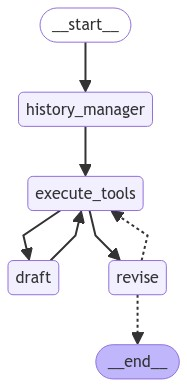

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
class Message(TypedDict):
    role: str
    content: str
    
query = "How should we handle the climate crisis?"

events = graph.stream(
    {[HumanMessage(content="How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    rich.print(step)

TypeError: unhashable type: 'list'

## Conclusion

Congrats on building a Reflexion actor! I'll leave you with a few observations to save you some time when choosing which parts of this agent to adapt to your workflow:
1. This agent trades off execution time for quality. It explicitly forces the agent to critique and revise the output over several steps, which usually (not always) increases the response quality but takes much longer to return a final answer
2. The 'reflections' can be paired with additional external feedback (such as validators), to further guide the actor.
3. In the paper, 1 environment (AlfWorld) uses external memory. It does this by storing summaries of the reflections to an external store and using them in subsequent trials/invocations.